In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/StressAnalysis")

In [ ]:
batch_size = 32
class_names = ["Normal_Posts","Depressed_Posts"]
vocab_file = 'vocab.txt'
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( "Train",
                                                                    batch_size=batch_size,
                                                                    class_names = class_names,
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=1337,
                                                                    shuffle = True,
                                                                )
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(   "Train",
                                                                    batch_size=batch_size,
                                                                    class_names = class_names,
                                                                    validation_split=0.2,
                                                                    subset="validation",
                                                                    seed=1337,
                                                                    shuffle = False,
                                                                )

Found 10586 files belonging to 2 classes.
Using 8469 files for training.
Found 10586 files belonging to 2 classes.
Using 2117 files for validation.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

b"I just finished Siegmeyer's quest. Never forget.\n \nHello.\n\n&#x200B;\n\nSure, I already knew it. I know the steps, I did in the classic DS version... I was only thinking in that sweet, nice titanite chunk...\n\n&#x200B;\n\nBut then I had to talk to Sieglinde. She was sad, she cried.\n\nI am sad too now.\n\n&#x200B;\n\nRest in Piece, Onion Knight. Your bravery made me smile, your encounter in Anor Londo, that first time years ago, made me confident enough to take down those Silver Knights. You are my favourite character. \n\n&#x200B;\n\nNever forget."
0
b'In the summer of 1993, six hikers died in the Siberian mountains, suffering from violent, unexplained symptoms. One young girl lived to tell the tale.\n \nHello, all! First post here, and it\'s a wild one. Given the similarities to the infamous Dyatlov Pass Incident, I\'m surprised no one has written about this one before! It\'s difficult to find resources in English, and I\'m not a native Russian speaker, so... bear with me.\n\nO

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import string
import re

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped = tf.strings.regex_replace(lowercase, "\n", " ")
    return tf.strings.regex_replace(
        stripped, "[%s]" % re.escape(string.punctuation), ""
    )

# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 1000

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

try:
    print ("attempting to recover previous vocabulary...")

    f = open(vocab_file, 'r')
    vocab = f.read().split('\n')
    vocab = vocab[1:]
    vectorize_layer.set_vocabulary(vocab, df_data=None, oov_df_value=None)
    print ('previous vocabulary loaded')
except:
    print ('Exsisting vocabulary not found creating new vocabulary')
    print ("Making text-only dataset")
    # Making a text-only dataset to for adapting the vectorize layer:
    text_ds = raw_train_ds.map(lambda x, y: x)
    print ("adapting vector layer")
    vectorize_layer.adapt(text_ds)
    print ('backing up the voacbulary')
    vocab = vectorize_layer.get_vocabulary()
    f = open(vocab_file, 'w')
    voc = str()
    for v in vocab:
        voc = voc+'\n'+v
    f.write(voc)
    print ('Vocabulary generated and backed up')


Making text-only dataset
attempting to recover previous vocabulary...
previous vocabulary loaded


In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

# Do async prefetching / buffering of the data for best performance on GPU.
train_ds = train_ds.cache().prefetch(buffer_size=10)
val_ds = val_ds.cache().prefetch(buffer_size=10)

In [ ]:
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Adding a layer to map those vocab indices.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.3)(x)

# LSTM layer
x = layers.Bidirectional(layers.LSTM(embedding_dim))(x)

# Adding fully connected hidden layers:
x = layers.Dense(embedding_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# Projecting onto a single unit output layer, with sigmoid activation function:
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

opt = tf.keras.optimizers.Adam(learning_rate=0.001,)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256  

In [ ]:
epochs = 20

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')

callbacks = [reduce_lr]

# Fit the model using the train and test datasets.
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/20
265/265 [==============================] - 33s 115ms/step - loss: 0.4285 - accuracy: 0.7930 - val_loss: 0.1617 - val_accuracy: 0.9301
Epoch 2/20
265/265 [==============================] - 31s 116ms/step - loss: 0.0891 - accuracy: 0.9693 - val_loss: 0.1121 - val_accuracy: 0.9617
Epoch 3/20
265/265 [==============================] - 30s 113ms/step - loss: 0.0354 - accuracy: 0.9885 - val_loss: 0.1377 - val_accuracy: 0.9684
Epoch 4/20
265/265 [==============================] - 30s 114ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 0.1359 - val_accuracy: 0.9792
Epoch 5/20
265/265 [==============================] - 30s 113ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.1045 - val_accuracy: 0.9858
Epoch 6/20
265/265 [==============================] - 30s 112ms/step - loss: 0.0051 - accuracy: 0.9992 - val_loss: 0.0955 - val_accuracy: 0.9868
Epoch 7/20
265/265 [==============================] - 30s 114ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0919 - val_ac

In [ ]:
model.evaluate(val_ds)

67/67 [==============================] - 2s 33ms/step - loss: 0.0848 - accuracy: 0.9906


[0.08476509153842926, 0.9905526638031006]

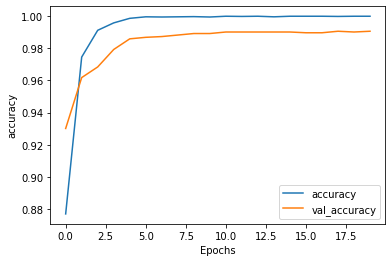

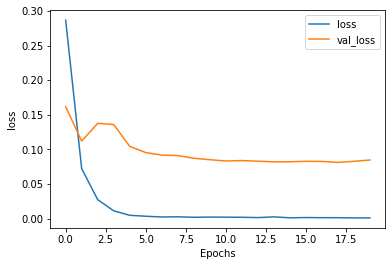

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
model.save('binary_model_LSTM.h5')

In [ ]:
model.save('binary_model_LSTM.tf')

INFO:tensorflow:Assets written to: binary_model_LSTM.tf/assets


INFO:tensorflow:Assets written to: binary_model_LSTM.tf/assets


In [ ]:
# A string input
inputs = tf.keras.Input(shape=(1,), dtype="string")
# Turn strings into vocab indices
indices = vectorize_layer(inputs)
# Turn vocab indices into predictions
outputs = model(indices)

# Our end to end model
end_to_end_model = tf.keras.Model(inputs, outputs)
end_to_end_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Test it with raw strings
end_to_end_model.evaluate(raw_val_ds)

67/67 [==============================] - 5s 62ms/step - loss: 0.1051 - accuracy: 0.9904


[0.08476509153842926, 0.9905526638031006]

In [ ]:
end_to_end_model.save("end_to_end_binary_LSTM_001.tf")

INFO:tensorflow:Assets written to: end_to_end_binary_LSTM_001.tf/assets


INFO:tensorflow:Assets written to: end_to_end_binary_LSTM_001.tf/assets


In [ ]:
#predict function
def predict_post(string):
    pred = end_to_end_model.predict(string)
    print(pred)
    pred = int(np.round(pred[0][0]))
    print (pred)
    print (class_names[pred])

In [ ]:
text = ['Just a discussion\n \n I was just wondering how hallowed be thy name fits so perfectly with this game . \n" I\'m waiting in my cell, when the bells begins to chime".']
predict_post(text)

[[7.4789774e-08]]
0
Normal_Posts


In [ ]:
text = ['I am tired \n tired of waiting, I am not waiting anymore I want it to be over it hurts me and my family.']
predict_post(text)

[[0.9999956]]
1
Depressed_Posts


In [ ]:
text = ['I am reckless \n my reckless attitude towards everything just costed me the life of my pet. The pain is unbearable.']
predict_post(text)

[[0.9997968]]
1
Depressed_Posts


In [ ]:
text = ['Every day \n Every day we stray further from god. Who will help us once god is upset and fed up with this world']
predict_post(text)

[[0.06149744]]
0
Normal_Posts
